In [2]:
from jcopdl.callback import set_config

In [11]:
data = "damped_sine"
# data = "jkse"

config = set_config({
    "input_size": 1,
    "seq_len": 5,
    "batch_size": 32,
    "output_size": 1,
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.2,
    "bidirectional": True, # True/False
    "cell_type": "lstm" # rnn/gru/lstm
})

lr = 0.001

# Jangan edit code di bawah ini

(N, S, F): (387, 5, 1)
Note: last 4 data excluded

(N, S, F): (97, 5, 1)
Note: last 0 data excluded





Epoch     1
Train_cost  = 1.1714 | Test_cost  = 0.0183 | 




Epoch     2
Train_cost  = 0.1688 | Test_cost  = 0.0597 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0183




Epoch     3
Train_cost  = 0.1198 | Test_cost  = 0.0320 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0183




Epoch     4
Train_cost  = 0.1264 | Test_cost  = 0.0021 | 




Epoch     5
Train_cost  = 0.1142 | Test_cost  = 0.0069 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0021




Epoch     6
Train_cost  = 0.0747 | Test_cost  = 0.0018 | 




Epoch     7
Train_cost  = 0.1628 | Test_cost  = 0.0075 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0018




Epoch     8
Train_cost  = 0.0529 | Test_cost  = 0.0021 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0018




Epoch     9
Train_cost  = 0.0752 | Test_cost  = 0.0127 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0018




Epoch    10
Train_cost  = 0.0299 | Test_cost  = 0.0023 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0018




Epoch    11
Train_cost  = 0.0576 | Test_cost  = 0.0082 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0018
==> Execute Early Stopping at epoch: 11 | Best test_cost: 0.0018
==> Best model is saved at model/damped_sine/


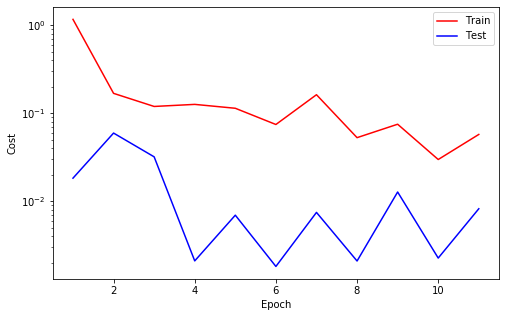

(N, S, F): (1939, 1, 1)
Note: last 0 data excluded

(N, S, F): (485, 1, 1)
Note: last 0 data excluded



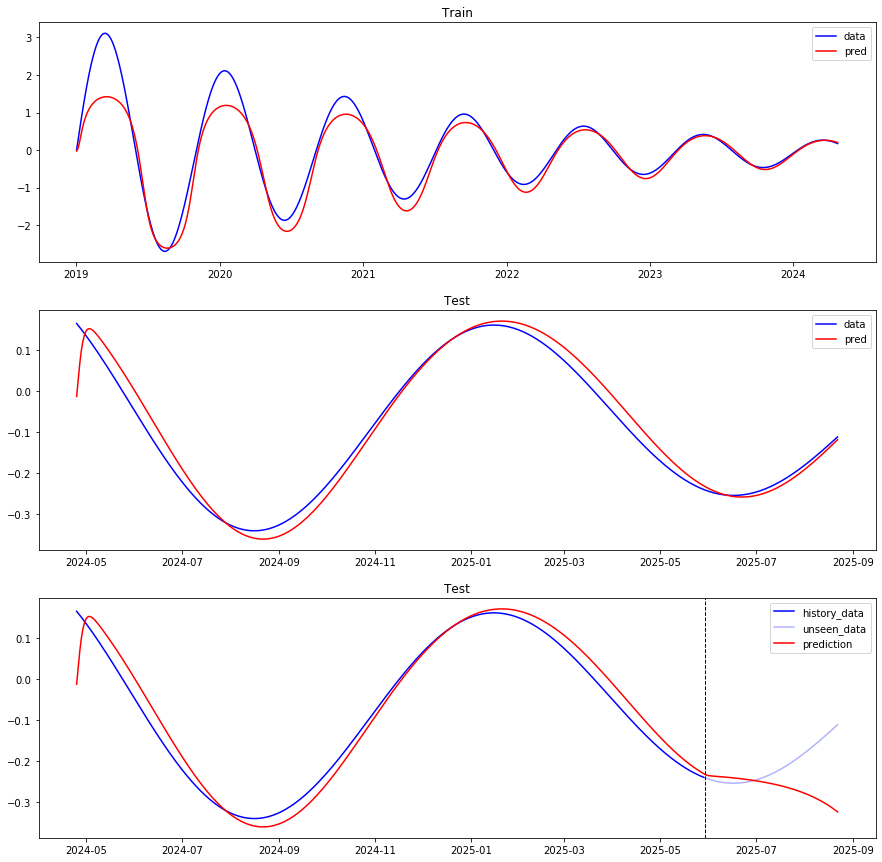

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader
from utils import data4pred, pred4pred

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

class RNN(nn.Module):
    def __init__(self, cell_type, input_size, output_size, hidden_size, num_layers, dropout, bidirectional):
        super().__init__()
        
        if cell_type == "rnn":
            rnn_block = nn.RNN
        elif cell_type == "lstm":
            rnn_block = nn.LSTM
        elif cell_type == "gru":
            rnn_block = nn.GRU
        
        self.rnn = rnn_block(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional:
            hidden_size = 2*hidden_size
            
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
    
if data == "damped_sine":
    df = pd.read_csv("data/sine_new.csv", parse_dates=["Date"], index_col="Date")
    df.value = df.value.transform(lambda x: (x-x.mean())/x.std())
    col = "value"    
elif data == "jkse":
    df = pd.read_csv("data/jkse.csv", parse_dates=["Date"], index_col="Date")
    df = df[~df.price.isna()]
    df.price = df.price.transform(lambda x: (x-x.mean())/x.std())
    col = "price"

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)

train_set = TimeSeriesDataset(ts_train, col, config.seq_len)
trainloader = DataLoader(train_set, batch_size=config.batch_size)

test_set = TimeSeriesDataset(ts_test, col, config.seq_len)
testloader = DataLoader(test_set, batch_size=config.batch_size)

model = RNN(config.cell_type, config.input_size, config.output_size, config.hidden_size, 
            config.num_layers, config.dropout, config.bidirectional).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=lr)
callback = Callback(model, config, outdir=f'model/{data}/')

from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break
        
# Forecast
train_forecast_set = TimeSeriesDataset(ts_train, col, 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, col, 1)
testforecastloader = DataLoader(test_forecast_set)

plt.figure(figsize=(15, 15))
    
plt.subplot(311)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(312)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

plt.subplot(313)
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=400, n_forecast=100)
plt.title("Test");